In [1]:
import os
import re
import opensmile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from opensmile import FeatureSet, FeatureLevel
from contextlib import redirect_stdout

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters as hp

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
path = 'output/'
output_folder = os.listdir(path)
use_deprecated = False

In [3]:
dict_df_featuresets = {}
pattern = r'(Deprecated)'

for file in output_folder:
    csv_path = path+'/'+file
    temp_df = pd.read_csv(csv_path)
    temp_df = temp_df.drop(axis=1, columns = ['file', 'start', 'end'])
    if use_deprecated:    
        dict_df_featuresets[file[:-4]] = temp_df
    else:
        if re.findall(pattern, csv_path):
            pass
        else:
            dict_df_featuresets[file[:-4]] = temp_df

In [4]:
for featuresets in dict_df_featuresets:
    print(featuresets)
    
history_collection = {}

ComParE_2016
eGeMAPSv01a
eGeMAPSv02
emobase
GeMAPSv01a
GeMAPSv01b


In [5]:
def sm_model(num_of_features):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=8, strides = 1, activation='relu', input_shape=(num_of_features,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(128, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(64, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [6]:
features_df = (dict_df_featuresets['emobase'])
print(features_df.shape)

(1975, 989)


In [7]:
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [8]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_emobase = sm_model(number_of_features)
history_emobase = model_emobase.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_emobase.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['emobase'] = history_emobase

Epoch 1/100


W1113 15:50:01.632132 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000024783C88430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 15:50:17.077701 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024781D33A60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 16s - loss: 2.2219 - acc: 0.1990 - val_loss: 3.6052 - val_acc: 0.1398 - 16s/epoch - 186ms/step
Epoch 2/100
87/87 - 16s - loss: 1.8058 - acc: 0.3177 - val_loss: 4.5636 - val_acc: 0.1398 - 16s/epoch - 179ms/step
Epoch 3/100
87/87 - 16s - loss: 1.5957 - acc: 0.4023 - val_loss: 4.0081 - val_acc: 0.2265 - 16s/epoch - 180ms/step
Epoch 4/100
87/87 - 14s - loss: 1.4219 - acc: 0.4674 - val_loss: 3.5257 - val_acc: 0.1928 - 14s/epoch - 165ms/step
Epoch 5/100
87/87 - 15s - loss: 1.3061 - acc: 0.5159 - val_loss: 2.8512 - val_acc: 0.3012 - 15s/epoch - 168ms/step
Epoch 6/100
87/87 - 14s - loss: 1.1956 - acc: 0.5507 - val_loss: 1.4631 - val_acc: 0.4795 - 14s/epoch - 164ms/step
Epoch 7/100
87/87 -

Epoch 68/100
87/87 - 14s - loss: 0.1299 - acc: 0.9624 - val_loss: 1.8533 - val_acc: 0.6578 - 14s/epoch - 166ms/step
Epoch 69/100
87/87 - 15s - loss: 0.0938 - acc: 0.9740 - val_loss: 1.8082 - val_acc: 0.6675 - 15s/epoch - 170ms/step
Epoch 70/100
87/87 - 15s - loss: 0.0641 - acc: 0.9797 - val_loss: 2.0709 - val_acc: 0.6458 - 15s/epoch - 168ms/step
Epoch 71/100
87/87 - 16s - loss: 0.0740 - acc: 0.9754 - val_loss: 1.9906 - val_acc: 0.6627 - 16s/epoch - 181ms/step
Epoch 72/100
87/87 - 15s - loss: 0.0688 - acc: 0.9768 - val_loss: 1.9576 - val_acc: 0.6458 - 15s/epoch - 172ms/step
Epoch 73/100
87/87 - 15s - loss: 0.0679 - acc: 0.9805 - val_loss: 2.1447 - val_acc: 0.6337 - 15s/epoch - 177ms/step
Epoch 74/100
87/87 - 15s - loss: 0.0865 - acc: 0.9783 - val_loss: 2.1788 - val_acc: 0.6578 - 15s/epoch - 172ms/step
Epoch 75/100
87/87 - 15s - loss: 0.0989 - acc: 0.9711 - val_loss: 2.1277 - val_acc: 0.6217 - 15s/epoch - 168ms/step
Epoch 76/100
87/87 - 15s - loss: 0.0618 - acc: 0.9812 - val_loss: 2.0690

In [9]:
features_df = (dict_df_featuresets['ComParE_2016'])
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [10]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_ComParE_2016 = sm_model(number_of_features)
history_ComParE_2016 = model_ComParE_2016.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_ComParE_2016.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['ComParE_2016'] = history_ComParE_2016

Epoch 1/100


W1113 16:15:06.492591 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000024783AF4430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 16:16:48.114617 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000247820A65E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 106s - loss: 2.3747 - acc: 0.2562 - val_loss: 4.0735 - val_acc: 0.1422 - 106s/epoch - 1s/step
Epoch 2/100
87/87 - 114s - loss: 1.6888 - acc: 0.4088 - val_loss: 9.8322 - val_acc: 0.1108 - 114s/epoch - 1s/step
Epoch 3/100
87/87 - 108s - loss: 1.3966 - acc: 0.5065 - val_loss: 9.5162 - val_acc: 0.1205 - 108s/epoch - 1s/step
Epoch 4/100
87/87 - 110s - loss: 1.2377 - acc: 0.5803 - val_loss: 6.2132 - val_acc: 0.2096 - 110s/epoch - 1s/step
Epoch 5/100
87/87 - 110s - loss: 0.9237 - acc: 0.6700 - val_loss: 5.1085 - val_acc: 0.2819 - 110s/epoch - 1s/step
Epoch 6/100
87/87 - 112s - loss: 0.8192 - acc: 0.7055 - val_loss: 2.6535 - val_acc: 0.4410 - 112s/epoch - 1s/step
Epoch 7/100
87/87 - 106s 

Epoch 69/100
87/87 - 105s - loss: 0.0393 - acc: 0.9891 - val_loss: 3.7310 - val_acc: 0.5711 - 105s/epoch - 1s/step
Epoch 70/100
87/87 - 109s - loss: 0.0523 - acc: 0.9884 - val_loss: 3.3214 - val_acc: 0.5952 - 109s/epoch - 1s/step
Epoch 71/100
87/87 - 108s - loss: 0.0520 - acc: 0.9870 - val_loss: 3.5834 - val_acc: 0.6048 - 108s/epoch - 1s/step
Epoch 72/100
87/87 - 107s - loss: 0.0456 - acc: 0.9884 - val_loss: 3.5366 - val_acc: 0.6120 - 107s/epoch - 1s/step
Epoch 73/100
87/87 - 102s - loss: 0.1072 - acc: 0.9754 - val_loss: 3.6024 - val_acc: 0.6000 - 102s/epoch - 1s/step
Epoch 74/100
87/87 - 101s - loss: 0.0966 - acc: 0.9790 - val_loss: 3.7213 - val_acc: 0.5590 - 101s/epoch - 1s/step
Epoch 75/100
87/87 - 102s - loss: 0.0884 - acc: 0.9740 - val_loss: 3.6268 - val_acc: 0.5759 - 102s/epoch - 1s/step
Epoch 76/100
87/87 - 101s - loss: 0.0448 - acc: 0.9848 - val_loss: 3.3355 - val_acc: 0.6313 - 101s/epoch - 1s/step
Epoch 77/100
87/87 - 102s - loss: 0.0469 - acc: 0.9841 - val_loss: 3.4194 - val_

In [11]:
history_collection['ComParE_2016'] = history_ComParE_2016

In [12]:
features_df = (dict_df_featuresets['eGeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [13]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_eGeMAPSv01a = sm_model(number_of_features)
history_eGeMAPSv01a = model_eGeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['eGeMAPSv01a'] = history_eGeMAPSv01a

Epoch 1/100


W1113 19:26:31.916904 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000024783ADCDC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 19:26:34.030066 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000247829844C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 2s - loss: 2.4102 - acc: 0.1787 - val_loss: 2.1936 - val_acc: 0.1663 - 2s/epoch - 28ms/step
Epoch 2/100
87/87 - 1s - loss: 2.0749 - acc: 0.2221 - val_loss: 2.1560 - val_acc: 0.0723 - 1s/epoch - 16ms/step
Epoch 3/100
87/87 - 1s - loss: 1.9509 - acc: 0.2735 - val_loss: 2.0229 - val_acc: 0.2120 - 1s/epoch - 16ms/step
Epoch 4/100
87/87 - 1s - loss: 1.8222 - acc: 0.3003 - val_loss: 1.9559 - val_acc: 0.2578 - 1s/epoch - 16ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7442 - acc: 0.3256 - val_loss: 1.7478 - val_acc: 0.3422 - 1s/epoch - 16ms/step
Epoch 6/100
87/87 - 1s - loss: 1.7201 - acc: 0.3386 - val_loss: 1.6086 - val_acc: 0.4024 - 1s/epoch - 16ms/step
Epoch 7/100
87/87 - 1s - loss: 1.6610

Epoch 70/100
87/87 - 1s - loss: 0.8545 - acc: 0.6823 - val_loss: 1.1948 - val_acc: 0.5687 - 1s/epoch - 16ms/step
Epoch 71/100
87/87 - 1s - loss: 0.8776 - acc: 0.6780 - val_loss: 1.1576 - val_acc: 0.5855 - 1s/epoch - 16ms/step
Epoch 72/100
87/87 - 1s - loss: 0.8413 - acc: 0.6903 - val_loss: 1.1512 - val_acc: 0.5783 - 1s/epoch - 16ms/step
Epoch 73/100
87/87 - 1s - loss: 0.8386 - acc: 0.6860 - val_loss: 1.1747 - val_acc: 0.5711 - 1s/epoch - 16ms/step
Epoch 74/100
87/87 - 1s - loss: 0.8480 - acc: 0.6874 - val_loss: 1.1887 - val_acc: 0.5855 - 1s/epoch - 16ms/step
Epoch 75/100
87/87 - 1s - loss: 0.8349 - acc: 0.6867 - val_loss: 1.1693 - val_acc: 0.6072 - 1s/epoch - 16ms/step
Epoch 76/100
87/87 - 1s - loss: 0.8111 - acc: 0.7077 - val_loss: 1.1886 - val_acc: 0.5952 - 1s/epoch - 16ms/step
Epoch 77/100
87/87 - 1s - loss: 0.8262 - acc: 0.6910 - val_loss: 1.1748 - val_acc: 0.5783 - 1s/epoch - 16ms/step
Epoch 78/100
87/87 - 1s - loss: 0.8333 - acc: 0.6896 - val_loss: 1.1913 - val_acc: 0.5904 - 1s/e

In [14]:
features_df = (dict_df_featuresets['eGeMAPSv02'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [15]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_eGeMAPSv02 = sm_model(number_of_features)
history_eGeMAPSv02 = model_eGeMAPSv02.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv02.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['eGeMAPSv02'] = history_eGeMAPSv02

Epoch 1/100


W1113 19:28:52.572118 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000024783AB7F70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 19:28:54.575392 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024783D9E4C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 2s - loss: 2.5188 - acc: 0.1483 - val_loss: 2.1860 - val_acc: 0.1494 - 2s/epoch - 25ms/step
Epoch 2/100
87/87 - 1s - loss: 2.1002 - acc: 0.2279 - val_loss: 2.1965 - val_acc: 0.1639 - 1s/epoch - 16ms/step
Epoch 3/100
87/87 - 1s - loss: 1.9034 - acc: 0.2902 - val_loss: 2.1861 - val_acc: 0.1831 - 1s/epoch - 16ms/step
Epoch 4/100
87/87 - 1s - loss: 1.8460 - acc: 0.3054 - val_loss: 2.0763 - val_acc: 0.2193 - 1s/epoch - 16ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7652 - acc: 0.3343 - val_loss: 1.8665 - val_acc: 0.3108 - 1s/epoch - 16ms/step
Epoch 6/100
87/87 - 1s - loss: 1.6855 - acc: 0.3517 - val_loss: 1.6604 - val_acc: 0.3518 - 1s/epoch - 16ms/step
Epoch 7/100
87/87 - 1s - loss: 1.6515

Epoch 70/100
87/87 - 1s - loss: 0.8334 - acc: 0.7004 - val_loss: 1.2061 - val_acc: 0.5446 - 1s/epoch - 16ms/step
Epoch 71/100
87/87 - 1s - loss: 0.8328 - acc: 0.6983 - val_loss: 1.2390 - val_acc: 0.5494 - 1s/epoch - 16ms/step
Epoch 72/100
87/87 - 1s - loss: 0.8080 - acc: 0.6918 - val_loss: 1.2247 - val_acc: 0.5494 - 1s/epoch - 16ms/step
Epoch 73/100
87/87 - 1s - loss: 0.8041 - acc: 0.6961 - val_loss: 1.2202 - val_acc: 0.5783 - 1s/epoch - 16ms/step
Epoch 74/100
87/87 - 1s - loss: 0.8188 - acc: 0.6874 - val_loss: 1.2126 - val_acc: 0.5566 - 1s/epoch - 16ms/step
Epoch 75/100
87/87 - 1s - loss: 0.7519 - acc: 0.7229 - val_loss: 1.2053 - val_acc: 0.5831 - 1s/epoch - 16ms/step
Epoch 76/100
87/87 - 1s - loss: 0.8179 - acc: 0.7098 - val_loss: 1.2042 - val_acc: 0.5831 - 1s/epoch - 16ms/step
Epoch 77/100
87/87 - 1s - loss: 0.8072 - acc: 0.6939 - val_loss: 1.1977 - val_acc: 0.5735 - 1s/epoch - 16ms/step
Epoch 78/100
87/87 - 1s - loss: 0.7648 - acc: 0.7156 - val_loss: 1.2315 - val_acc: 0.5398 - 1s/e

In [16]:
features_df = (dict_df_featuresets['GeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [17]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_GeMAPSv01a = sm_model(number_of_features)
history_GeMAPSv01a = model_GeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['GeMAPSv01a'] = history_GeMAPSv01a

Epoch 1/100


W1113 19:31:10.667431 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x00000247841C3F70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 19:31:12.110376 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024784D7F430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 2s - loss: 2.3671 - acc: 0.1599 - val_loss: 2.1414 - val_acc: 0.1253 - 2s/epoch - 19ms/step
Epoch 2/100
87/87 - 1s - loss: 2.0223 - acc: 0.2598 - val_loss: 2.1156 - val_acc: 0.1831 - 773ms/epoch - 9ms/step
Epoch 3/100
87/87 - 1s - loss: 1.8701 - acc: 0.3039 - val_loss: 2.0550 - val_acc: 0.2072 - 803ms/epoch - 9ms/step
Epoch 4/100
87/87 - 1s - loss: 1.8067 - acc: 0.2959 - val_loss: 1.9435 - val_acc: 0.3012 - 804ms/epoch - 9ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7945 - acc: 0.3054 - val_loss: 1.7726 - val_acc: 0.3373 - 798ms/epoch - 9ms/step
Epoch 6/100
87/87 - 1s - loss: 1.7079 - acc: 0.3321 - val_loss: 1.6234 - val_acc: 0.3687 - 779ms/epoch - 9ms/step
Epoch 7/100
87/87 - 1s - lo

Epoch 69/100
87/87 - 1s - loss: 1.0226 - acc: 0.6266 - val_loss: 1.1616 - val_acc: 0.5639 - 801ms/epoch - 9ms/step
Epoch 70/100
87/87 - 1s - loss: 0.9827 - acc: 0.6360 - val_loss: 1.1669 - val_acc: 0.5807 - 799ms/epoch - 9ms/step
Epoch 71/100
87/87 - 1s - loss: 0.9821 - acc: 0.6368 - val_loss: 1.1368 - val_acc: 0.5711 - 807ms/epoch - 9ms/step
Epoch 72/100
87/87 - 1s - loss: 0.9814 - acc: 0.6462 - val_loss: 1.1304 - val_acc: 0.5590 - 781ms/epoch - 9ms/step
Epoch 73/100
87/87 - 1s - loss: 0.9928 - acc: 0.6266 - val_loss: 1.1154 - val_acc: 0.5831 - 794ms/epoch - 9ms/step
Epoch 74/100
87/87 - 1s - loss: 1.0227 - acc: 0.6259 - val_loss: 1.1368 - val_acc: 0.5904 - 802ms/epoch - 9ms/step
Epoch 75/100
87/87 - 1s - loss: 0.9635 - acc: 0.6418 - val_loss: 1.1319 - val_acc: 0.5807 - 806ms/epoch - 9ms/step
Epoch 76/100
87/87 - 1s - loss: 0.9340 - acc: 0.6476 - val_loss: 1.1318 - val_acc: 0.5904 - 803ms/epoch - 9ms/step
Epoch 77/100
87/87 - 1s - loss: 0.9704 - acc: 0.6425 - val_loss: 1.1382 - val_ac

In [18]:
features_df = (dict_df_featuresets['GeMAPSv01b'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [19]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_GeMAPSv01b = sm_model(number_of_features)
history_GeMAPSv01b = model_GeMAPSv01b.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01b.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['GeMAPSv01a'] = history_GeMAPSv01b

Epoch 1/100


W1113 19:32:31.792907 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000024784EAE5E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 19:32:33.525911 16148 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024783D9E8B0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 2s - loss: 2.3179 - acc: 0.1787 - val_loss: 2.1500 - val_acc: 0.1807 - 2s/epoch - 22ms/step
Epoch 2/100
87/87 - 1s - loss: 2.0249 - acc: 0.2395 - val_loss: 2.0994 - val_acc: 0.1952 - 810ms/epoch - 9ms/step
Epoch 3/100
87/87 - 1s - loss: 1.9405 - acc: 0.2540 - val_loss: 2.0036 - val_acc: 0.2145 - 802ms/epoch - 9ms/step
Epoch 4/100
87/87 - 1s - loss: 1.8721 - acc: 0.3003 - val_loss: 1.8872 - val_acc: 0.2867 - 805ms/epoch - 9ms/step
Epoch 5/100
87/87 - 1s - loss: 1.8377 - acc: 0.2952 - val_loss: 1.7281 - val_acc: 0.3277 - 812ms/epoch - 9ms/step
Epoch 6/100
87/87 - 1s - loss: 1.7302 - acc: 0.3271 - val_loss: 1.6234 - val_acc: 0.3952 - 807ms/epoch - 9ms/step
Epoch 7/100
87/87 - 1s - lo

Epoch 69/100
87/87 - 1s - loss: 0.9493 - acc: 0.6541 - val_loss: 1.1784 - val_acc: 0.5639 - 806ms/epoch - 9ms/step
Epoch 70/100
87/87 - 1s - loss: 0.9963 - acc: 0.6281 - val_loss: 1.1504 - val_acc: 0.5735 - 812ms/epoch - 9ms/step
Epoch 71/100
87/87 - 1s - loss: 1.0131 - acc: 0.6310 - val_loss: 1.1720 - val_acc: 0.5687 - 790ms/epoch - 9ms/step
Epoch 72/100
87/87 - 1s - loss: 0.9398 - acc: 0.6469 - val_loss: 1.2053 - val_acc: 0.5614 - 798ms/epoch - 9ms/step
Epoch 73/100
87/87 - 1s - loss: 0.9935 - acc: 0.6368 - val_loss: 1.1785 - val_acc: 0.5663 - 807ms/epoch - 9ms/step
Epoch 74/100
87/87 - 1s - loss: 0.9453 - acc: 0.6411 - val_loss: 1.1630 - val_acc: 0.5614 - 806ms/epoch - 9ms/step
Epoch 75/100
87/87 - 1s - loss: 0.9420 - acc: 0.6592 - val_loss: 1.1536 - val_acc: 0.5759 - 808ms/epoch - 9ms/step
Epoch 76/100
87/87 - 1s - loss: 0.9914 - acc: 0.6331 - val_loss: 1.1399 - val_acc: 0.5759 - 799ms/epoch - 9ms/step
Epoch 77/100
87/87 - 1s - loss: 0.9619 - acc: 0.6310 - val_loss: 1.1443 - val_ac

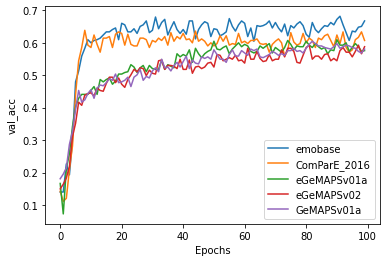

In [20]:
plot_data_testAcc = []
plot_data_testLoss = []
plot_data_trainAcc = []
plot_data_trainLoss = []
for history in history_collection:
    plt.plot(list(range(len(history_collection[history].history['val_acc']))), history_collection[history].history['val_acc'], label = history)
plt.xlabel('Epochs')
plt.ylabel('val_acc')
plt.legend()

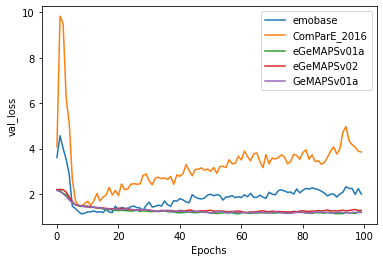

In [21]:
plot_data_testAcc = []
plot_data_testLoss = []
plot_data_trainAcc = []
plot_data_trainLoss = []
for history in history_collection:
    plt.plot(list(range(len(history_collection[history].history['val_loss']))), history_collection[history].history['val_loss'], label = history)
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.legend()

In [22]:
print(model_GeMAPSv01b.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 55, 256)           2304      
                                                                 
 batch_normalization_15 (Bat  (None, 55, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 27, 256)          0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 27, 256)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 20, 128)           262272    
                                                                 
 batch_normalization_16 (Bat  (None, 20, 128)         